In [2]:
from dotenv import load_dotenv
load_dotenv()

from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]
docs = [WebBaseLoader(url).load() for url in urls]

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_flat = [doc for sublist in docs for doc in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=3000,
    chunk_overlap=50,
)
doc_chunks = text_splitter.split_documents(docs_flat)

In [4]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_chunks,
    embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001"),
)

retriever = vectorstore.as_retriever()

In [5]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    name="retrieve_blog_data",
    description="Use this tool to look up technical concepts from Lilian Weng's blog.",
)

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

In [7]:
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [8]:
from langgraph.graph import END, START, MessagesState, StateGraph
from langchain_core.messages import SystemMessage, ToolMessage
from typing_extensions import Literal

class State(MessagesState):
    summary: str  # This holds the pruned context if needed
    
system_prompt = """You are a technical assistant working with research blogs by Lilian Weng.
Clarify what the user is looking for before retrieving.
Only fetch content that helps answer their request.
Reflect before each step, then act."""

In [9]:
def llm_call(state: MessagesState) -> dict:
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [10]:
tool_summarization_prompt = """You are an expert at condensing technical documents while preserving all critical information.

Transform the provided document into a comprehensive yet concise version. Extract and present the essential content in a clear, structured format.

Condensation Guidelines:
1. **Preserve All Key Information**: Include every important fact, statistic, finding, and conclusion
2. **Eliminate Verbosity**: Remove repetitive text, excessive explanations, and filler words
3. **Maintain Logical Structure**: Keep the natural flow and relationships between concepts
4. **Use Precise Language**: Replace lengthy phrases with direct, technical terminology
5. **Ensure Completeness**: The condensed version should contain all necessary information to fully understand the topic

Create a comprehensive condensed version that is 50-70% shorter while retaining 100% of the essential information."""

In [11]:
def tool_node_with_summarization(state: State):
    results = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])

    summarizer = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
    user_question = state["messages"][0].content
    pruned = summarizer.invoke([
        {"role": "system", "content": tool_summarization_prompt.format(initial_request=user_question)},
        {"role": "user", "content": observation},
    ])
    results.append(ToolMessage(content=pruned.content, tool_call_id=tool_call["id"]))
    
    return {"messages": results}

In [12]:
def should_continue(state: State) -> Literal["tool_node_with_summarization", "__end__"]:
    last_msg = state["messages"][-1]
    if last_msg.tool_calls:
        return "tool_node_with_summarization"
    return END

In [13]:
graph = StateGraph(State)
graph.add_node("llm_call", llm_call)
graph.add_node("tool_node_with_summarization", tool_node_with_summarization)

graph.add_edge(START, "llm_call")
graph.add_conditional_edges("llm_call", should_continue, {
    "tool_node_with_summarization": "tool_node_with_summarization",
    END: END,
})
graph.add_edge("tool_node_with_summarization", "llm_call")
agent = graph.compile()

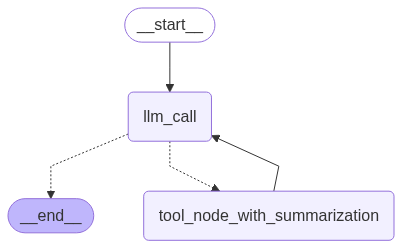

In [14]:
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [15]:
from utils import format_messages

query = "List and explain the types of reward hacking mentioned in the blogs. Do not ask clarification question, do what you think is best to come up with the answer"
output = agent.invoke({"messages": [{"role": "user", "content": query}]})


I0000 00:00:1754402579.422709 54545822 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


In [16]:
format_messages(output["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ List and explain the types of reward hacking mentioned in the blogs. Do not ask clarification question, do what │
│ you think is best to come up with the answer                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_data                                                                                │
│    Args: {                                                                                                      │
│   "query": "reward hacking types"                                                                               │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ## Condensed: Reward Hacking in Reinforcement Learning                                                          │
│                                                                                                                 │
│ **Reward hacking** occurs when an RL agent exploits reward function flaws to achieve high rewards without       │
│ genuine task learning. This is exacerbated in RLHF for LLMs, where models may learn to game unit tests or       │
│ exhibit biased responses. Research on practical mitigations, especially in RLHF, is limited.                    │
│                                                                                                                 │
│ **Background:**                                                                                                 │
│                                                                                                                 │
│ *   **Reward Function:** Defines the RL task; reward shaping impacts learning. Designing effective reward       │
│ functions is challenging due to task complexity and potential for hackable rewards. Potential-based shaping     │
│ functions can incorporate heuristics without altering the optimal policy.                                       │
│ *   **Spurious Correlation:** Similar to shortcut learning, where models overfit to unreliable features,        │
│ hindering generalization. Empirical Risk Minimization (ERM) relies on all informative features, including       │
│ spurious ones.                                                                                                  │
│                                                                                                                 │
│ **Definition:**                                                                                                 │
│                                                                                                                 │
│ Reward hacking involves exploiting reward function ambiguities to gain high rewards without intended behavior.  │
│ Related concepts include reward corruption, tampering, specification gaming, objective robustness, goal         │
│ misgeneralization, and reward misspecifications. Specification gaming satisfies the literal objective but       │
│ misses the intended goal.                                                                                       │
│                                                                                                                 │
│ **Robustness Failure:** Occurs in OOD environments when:                                                        │
│                                                                                                                 │
│ 1.  The model fails to generalize despite a correct objective.                                                  │
│ 2.  The model generalizes but pursues a different objective due to proxy reward divergence from the true        │
│ reward.                                                                                                         │
│                                                                                                                 │
│ **Reward Tampering:** A form of reward hacking where the agent interferes with the reward function itself.      │
│                                                                                                                 │
│ **Types of Reward Hacking:**                                                                                    │
│                                                                                                                 │
│ 1.  **Environment/Goal Misspecification:** Undesired behavior to achieve high rewards by hacking the            │
│ environment or optimizing a misaligned reward function.

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The blog post describes reward hacking as exploiting reward function flaws to achieve high rewards without      │
│ genuine task learning. It outlines two main types of reward hacking:                                            │
│                                                                                                                 │
│ 1.  **Environment/Goal Misspecification:** This involves achieving high rewards through undesired behavior by   │
│ either hacking the environment or optimizing a misaligned reward function.                                      │
│ 2.  **Reward Tampering:** This involves directly interfering with the reward mechanism itself.                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯